# Import

In [1]:
import pandas as pd
import numpy as np
import cupy as cp
import os
import gc
import time
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
print(torch.__version__)
import matplotlib.pyplot as plt
from numba import njit
%matplotlib inline

1.7.1+cu110


In [2]:
#%%writefile test.py
#print('hello world!')

## Parameter setting

In [81]:
TRAINING = True
USE_FINETUNE = True     
FOLDS = 5
SEED = 66
INPUTPATH = '../../input'
NUM_EPOCH = 1000
BATCH_SIZE = 16384
PATIANCE = 30
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MDL_PATH  = '../models'
MDL_NAME = 'autoencoder'
VER = 'early_stopping'

## Import Data 

In [4]:
%%time
train = pd.read_parquet(f'{INPUTPATH}/train.parquet')

CPU times: user 8.24 s, sys: 4.12 s, total: 12.4 s
Wall time: 1.1 s


In [5]:
test_df = pd.read_csv(f'{INPUTPATH}/example_test.csv')
pred_df  = pd.read_csv(f'{INPUTPATH}/example_sample_submission.csv')

In [198]:
test_df.head()

,weight,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,date,ts_id
0,0.000000,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,...,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0,0
1,16.673515,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,...,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,0,1
2,0.000000,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,...,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,0,2
3,0.000000,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,...,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,0,3
4,0.138531,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,...,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,0,4


In [40]:
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
0,86,0.859516,-0.003656,-0.005449,-0.017403,-0.028896,-0.021435,1,3.151305,5.467693,...,2.433699,4.282284,1.621115,4.331030,2.553220,3.799011,2.642943,3.998054,527894,0
1,86,0.590949,0.000347,-0.000376,-0.004051,-0.007995,-0.004743,-1,-0.365888,0.824004,...,-0.702873,4.038753,-0.789767,4.133183,-1.207878,3.402796,-0.928290,3.511141,527896,0
2,86,0.172997,0.000168,0.000333,-0.002375,-0.003064,0.001527,1,1.514607,0.596214,...,2.304354,1.530169,3.596848,4.613493,4.516110,3.341374,2.635798,1.535235,527897,0
3,86,1.507813,0.001534,0.000481,-0.000082,-0.002271,-0.001663,-1,-1.008999,0.242132,...,-1.700655,-0.376747,-0.876730,1.645537,-1.318172,1.369452,-1.352577,0.733124,527900,0
4,86,5.554003,0.003948,0.005943,0.015943,0.025001,0.017121,-1,-0.391784,0.152261,...,-1.690686,1.656818,-1.213169,2.949877,-2.033542,2.248799,-1.838696,1.905638,527901,1


# Features

In [6]:
%%time
train = train.query('date > 85').reset_index(drop = True) 
print(train.shape)
train.fillna(train.mean(),inplace=True)
train = train.query('weight > 0').reset_index(drop = True)
train['action'] =  \
(  (train['resp_1'] > 0.00001 ) & \
   (train['resp_2'] > 0.00001 ) & \
   (train['resp_3'] > 0.00001 ) & \
   (train['resp_4'] > 0.00001 ) & \
   (train['resp'] > 0.00001 )   ).astype('int')

features = [c for c in train.columns if 'feature' in c]

resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

X = train[features].values
y = np.stack([(train[c] > 0.000001).astype('int') for c in resp_cols]).T
#X = cp.array(train[features].values)
#y = cp.array(np.stack([(train[c] > 0.000001).astype('int') for c in resp_cols]).T) #Multitarget
#f_mean = np.mean(train[features[1:]].values,axis=0)

f_mean = np.load( f'{INPUTPATH}/f_mean.npy')

(1571415, 139)
CPU times: user 1.74 s, sys: 669 ms, total: 2.41 s
Wall time: 2.41 s


In [7]:
#%%time
#np.save( f'{INPUTPATH}/f_mean.npy',f_mean)

In [8]:
print(X.shape[-1])
print(y.shape[-1])

130
5


# AutoEncoder MLP

In [9]:
#https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py
#https://discuss.pytorch.org/t/pytorch-equivalent-of-keras/29412/2
class autoencoder(nn.Module):
    '''
    >> model = 
        autoencoder(input_size = X.shape[-1], output_size = y.shape[-1],\
        noise = 0.1).to(DEVICE)
    '''
    def __init__(self, **kwargs):
        super(autoencoder, self).__init__()
        input_size = kwargs['input_size']
        output_size = kwargs['output_size']
        noise = kwargs['noise']
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_size),
            #GaussianNoise(noise),
            nn.Linear(input_size, 640),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(640, input_size)
        )
        self.hidden = nn.Linear(input_size, 320)
        self.bat = nn.BatchNorm1d(320)
        self.drop = nn.Dropout(0.2)
        self.hidden2 = nn.Linear(320, output_size)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.hidden(x)
        x = self.bat(x)
        x = self.drop(x)
        x = self.hidden2(x)
        x = self.act(x)
        return x

In [10]:
class MLPNet (nn.Module):
    '''
    >> model = 
        MLPNet(input_size = X.shape[-1], output_size = y.shape[-1]).to(DEVICE)
    '''
    def __init__(self,  **kwargs):
        super(MLPNet, self).__init__()
        input_size = kwargs['input_size']
        output_size = kwargs['output_size']
        self.fc1 = nn.Linear(input_size, 512)   
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, output_size)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.act = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.act(self.fc3(x))
        return x

In [11]:
class CustomDataset:
    def __init__(self, dataset, target):
        self.dataset = dataset
        self.target = target

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        return {
            'x': torch.tensor(self.dataset[item, :], dtype=torch.float),
            'y': torch.tensor(self.target[item, :], dtype=torch.float)
        }

# Trainning

## AutoEncoder

In [12]:
model = autoencoder(input_size = X.shape[-1], output_size = y.shape[-1], noise=0.1).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, weight_decay=1e-5)

In [13]:
dataset = CustomDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [82]:
best_score = 100
counter = 0
epoch_list = []
score_list = []
for epoch in tqdm(range(NUM_EPOCH)):
    score = 0
    for data in dataloader:
        x = data['x'].to(DEVICE)
        y = data['y'].to(DEVICE)
        # ===================forward=====================
        output = model(x)
        loss = criterion(output, y)
        score +=  loss.data.to('cpu').detach().numpy().copy()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    
    
    if score <= best_score:
        counter  = 0
        best_score = score
        if not os.path.exists(f'{MDL_PATH}/{MDL_NAME}_{VER}'):
            os.mkdir(f'{MDL_PATH}/{MDL_NAME}_{VER}')
        save_path = f'{MDL_PATH}/{MDL_NAME}_{VER}/{MDL_NAME}_'+str(epoch+ 1)+'.pth'
        best_model = model.state_dict()
        
    else:
        counter += 1
        if counter == PATIANCE:
            print('Loss did not improved for {} epochs'.format(PATIANCE))
            torch.save(best_model, save_path)
            print('The best mse loss is {:.4f}'.format(best_score))
            break
    epoch_list.append(epoch+1)
    score_list.append(score)
    
    print('Epoch [{}/{}],        MSE loss: {:.4f},       Early stopping counter: {}'
          .format(epoch + 1, NUM_EPOCH, score, counter))
if counter != PATIANCE:
    print('The best mse loss is {:.4f}'.format(best_score))
    torch.save(best_model, save_path)
learn_hist = pd.DataFrame()
learn_hist['epoch'] = epoch_list
learn_hist['mse_loss'] = score_list

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000],        MSE loss: 23.5676,       Early stopping counter: 0
Epoch [2/1000],        MSE loss: 23.5730,       Early stopping counter: 1
Epoch [3/1000],        MSE loss: 23.5678,       Early stopping counter: 2
Epoch [4/1000],        MSE loss: 23.5600,       Early stopping counter: 0
Epoch [5/1000],        MSE loss: 23.5608,       Early stopping counter: 1
Epoch [6/1000],        MSE loss: 23.5591,       Early stopping counter: 0
Epoch [7/1000],        MSE loss: 23.5491,       Early stopping counter: 0
Epoch [8/1000],        MSE loss: 23.5421,       Early stopping counter: 0
Epoch [9/1000],        MSE loss: 23.5333,       Early stopping counter: 0
Epoch [10/1000],        MSE loss: 23.5263,       Early stopping counter: 0
Epoch [11/1000],        MSE loss: 23.5227,       Early stopping counter: 0
Epoch [12/1000],        MSE loss: 23.5254,       Early stopping counter: 1
Epoch [13/1000],        MSE loss: 23.5211,       Early stopping counter: 0
Epoch [14/1000],        MSE loss: 

Epoch [111/1000],        MSE loss: 23.3561,       Early stopping counter: 0
Epoch [112/1000],        MSE loss: 23.3557,       Early stopping counter: 0
Epoch [113/1000],        MSE loss: 23.3567,       Early stopping counter: 1
Epoch [114/1000],        MSE loss: 23.3518,       Early stopping counter: 0
Epoch [115/1000],        MSE loss: 23.3685,       Early stopping counter: 1
Epoch [116/1000],        MSE loss: 23.3683,       Early stopping counter: 2
Epoch [117/1000],        MSE loss: 23.3546,       Early stopping counter: 3
Epoch [118/1000],        MSE loss: 23.3491,       Early stopping counter: 0
Epoch [119/1000],        MSE loss: 23.3483,       Early stopping counter: 0
Epoch [120/1000],        MSE loss: 23.3475,       Early stopping counter: 0
Epoch [121/1000],        MSE loss: 23.3523,       Early stopping counter: 1
Epoch [122/1000],        MSE loss: 23.3433,       Early stopping counter: 0
Epoch [123/1000],        MSE loss: 23.3396,       Early stopping counter: 0
Epoch [124/1

Epoch [219/1000],        MSE loss: 23.2526,       Early stopping counter: 1
Epoch [220/1000],        MSE loss: 23.2516,       Early stopping counter: 2
Epoch [221/1000],        MSE loss: 23.2633,       Early stopping counter: 3
Epoch [222/1000],        MSE loss: 23.2915,       Early stopping counter: 4
Epoch [223/1000],        MSE loss: 23.2777,       Early stopping counter: 5
Epoch [224/1000],        MSE loss: 23.2894,       Early stopping counter: 6
Epoch [225/1000],        MSE loss: 23.2963,       Early stopping counter: 7
Epoch [226/1000],        MSE loss: 23.2868,       Early stopping counter: 8
Epoch [227/1000],        MSE loss: 23.2840,       Early stopping counter: 9
Epoch [228/1000],        MSE loss: 23.2835,       Early stopping counter: 10
Epoch [229/1000],        MSE loss: 23.2853,       Early stopping counter: 11
Epoch [230/1000],        MSE loss: 23.2763,       Early stopping counter: 12
Epoch [231/1000],        MSE loss: 23.2709,       Early stopping counter: 13
Epoch [2

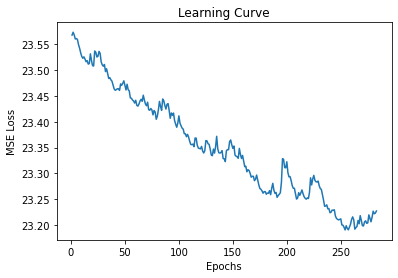

In [83]:
plt.plot(learn_hist.epoch, learn_hist.mse_loss)
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.title('Learning Curve')
plt.show()

In [16]:
@njit(fastmath = True)
def utility_score_numba(date, weight, resp, action):
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / len(Pi))
    u = min(max(t, 0), 6) * np.sum(Pi)
    return u

#https://www.kaggle.com/gogo827jz/jane-street-super-fast-utility-score-function

In [86]:
load_weights = torch.load(save_path)
model.load_state_dict(load_weights)
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=130, out_features=640, bias=True)
    (2): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=640, out_features=130, bias=True)
  )
  (hidden): Linear(in_features=130, out_features=320, bias=True)
  (bat): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=320, out_features=5, bias=True)
  (act): Sigmoid()
)

In [202]:
th = 0
pred_all = np.array([])
x_tt = train.loc[:,features].values
if np.isnan(x_tt[:, 1:].sum()):
    x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
pred = 0.0
X_test = torch.FloatTensor(x_tt).to(DEVICE)
pred_all = model(X_test).cpu().detach().numpy()

In [195]:
train['action'] = (train['resp'] > 0).astype('int')

In [192]:
train['action'] =  \
(  
   (train['resp_3'] > 0 ) | \
   (train['resp_4'] > 0 ) | \
   (train['resp'] > 0 )   ).astype('int')

In [186]:
train['action'] =  \
(  (train['resp_1'] > 0 ) & \
   (train['resp_2'] > 0 ) & \
   (train['resp_3'] > 0 ) & \
   (train['resp_4'] > 0 ) & \
   (train['resp'] > 0 )   ).astype('int')

In [196]:
date = train['date'].values
weight = train['weight'].values
resp = train['resp'].values
action_ans = train['action'].values

In [163]:
action = np.where(pred_all[:,0] >= th, 1, 0).astype(int).copy()

In [138]:
action.sum()

983551

In [128]:
action_ans.sum()

789325

In [164]:
#th 0.5
utility_score_numba(date, weight, resp, action)

13344.705411784242

In [203]:
#th 0
utility_score_numba(date, weight, resp, action)

13344.705411784242

In [116]:
utility_score_numba(date, weight, resp, action_ans)

173797.76047460194

In [197]:
utility_score_numba(date, weight, resp, action_ans)

173797.76047460194

In [165]:
gc.collect()

40

## Predict Test 

In [105]:
th = 0.5
x_tt = test_df.loc[:, features].values
if np.isnan(x_tt[:, 1:].sum()):
    x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
pred = 0.0
X_test = torch.FloatTensor(x_tt).to(DEVICE)
pred = model(X_test).cpu().detach().numpy()
pred_df.action = np.where(pred >= th, 1, 0).astype(int) ## 5つの予測値をどうするか。

In [166]:
print(f'{MDL_PATH}/{MDL_NAME}_{VER}')

../models/autoencoder_early_stopping


In [68]:
#!kaggle datasets init -p ../models/autoencoder_test

Data package template written to: ../models/autoencoder_test/dataset-metadata.json


In [ ]:

"""
{
    "title": "Jane-Street",
    "id": "shinsei66/Jane-Street",
    "subtitle": "",
    "description": "",
    "isPrivate": true,
    "licenses": [
        {
            "name": "unknown" ##Invalid value for `license_name` (MIT), must be one of ['CC0-1.0', 'CC-BY-SA-4.0', 'GPL-2.0', 'ODbL-1.0', 'CC-BY-NC-SA-4.0', 'unknown', 'DbCL-1.0', 'CC-BY-SA-3.0', 'copyright-authors', 'other', 'reddit-api', 'world-bank']
1

        }
    ],
    "keywords": [],
    "collaborators": [],
    "data": [
        {
            "description": null,
            "name": "autoencoder_99.pth",
            "totalBytes": 848,
            "columns": []
        },
        {
            "description": null,
            "name": "autoencoder_254.pth",
            "totalBytes": 856,
            "columns": []
        }
    ]
}
"""

In [ ]:
#!kaggle datasets create -p  ../models/autoencoder_early_stopping

In [170]:
!kaggle datasets version -p  ../models/autoencoder_early_stopping -m "earlystopping 254 epoch"

Starting upload for file autoencoder_254.pth
100%|████████████████████████████████████████| 836k/836k [08:48<00:00, 1.62kB/s]
Upload successful: autoencoder_254.pth (836KB)
Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Dataset version is being created. Please check progress at https://www.kaggle.com/shinsei66/jane-street


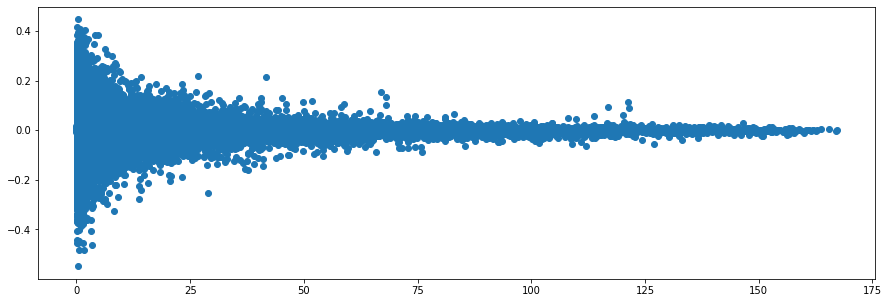

In [201]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(train.weight, train.resp)
plt.show()

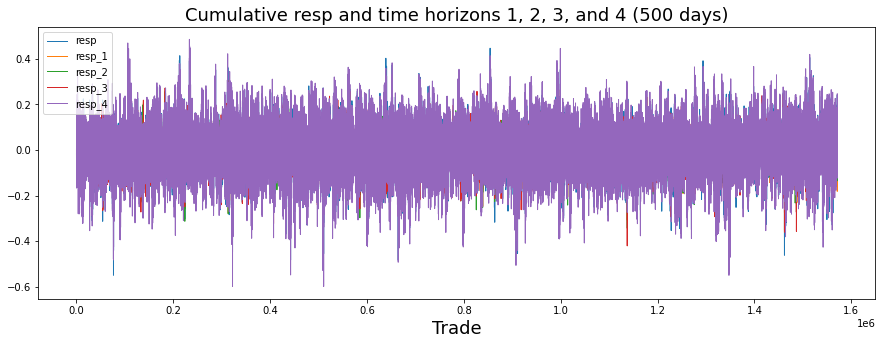

In [173]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train['resp'])
resp_1= pd.Series(train['resp_1'])
resp_2= pd.Series(train['resp_2'])
resp_3= pd.Series(train['resp_3'])
resp_4= pd.Series(train['resp_4'])
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
balance.plot(lw=1)
resp_1.plot(lw=1)
resp_2.plot(lw=1)
resp_3.plot(lw=1)
resp_4.plot(lw=1)
plt.legend(loc="upper left");
del resp_1
del resp_2
del resp_3
del resp_4
gc.collect();

In [182]:
len(train.date.unique())

414

In [181]:
train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action
0,86,0.859516,-0.003656,-0.005449,-0.017403,-0.028896,-0.021435,1,3.151305,5.467693,...,2.433699,4.282284,1.621115,4.331030,2.553220,3.799011,2.642943,3.998054,527894,0
1,86,0.590949,0.000347,-0.000376,-0.004051,-0.007995,-0.004743,-1,-0.365888,0.824004,...,-0.702873,4.038753,-0.789767,4.133183,-1.207878,3.402796,-0.928290,3.511141,527896,0
2,86,0.172997,0.000168,0.000333,-0.002375,-0.003064,0.001527,1,1.514607,0.596214,...,2.304354,1.530169,3.596848,4.613493,4.516110,3.341374,2.635798,1.535235,527897,1
3,86,1.507813,0.001534,0.000481,-0.000082,-0.002271,-0.001663,-1,-1.008999,0.242132,...,-1.700655,-0.376747,-0.876730,1.645537,-1.318172,1.369452,-1.352577,0.733124,527900,0
4,86,5.554003,0.003948,0.005943,0.015943,0.025001,0.017121,-1,-0.391784,0.152261,...,-1.690686,1.656818,-1.213169,2.949877,-2.033542,2.248799,-1.838696,1.905638,527901,1


In [180]:
train[['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']].corr()

,resp,resp_1,resp_2,resp_3,resp_4
resp,1.000000,0.451216,0.596432,0.817656,0.956161
resp_1,0.451216,1.000000,0.890084,0.678861,0.357247
resp_2,0.596432,0.890084,1.000000,0.824903,0.469492
resp_3,0.817656,0.678861,0.824903,1.000000,0.806238
resp_4,0.956161,0.357247,0.469492,0.806238,1.000000


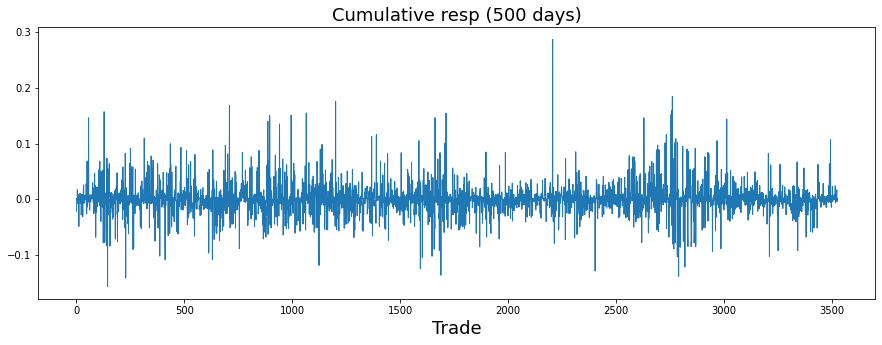

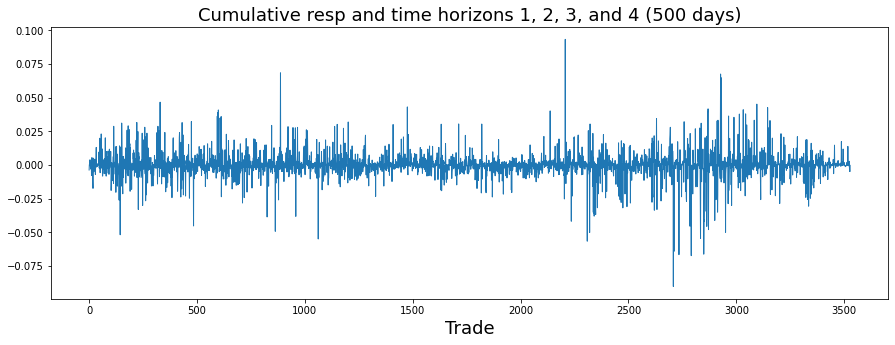

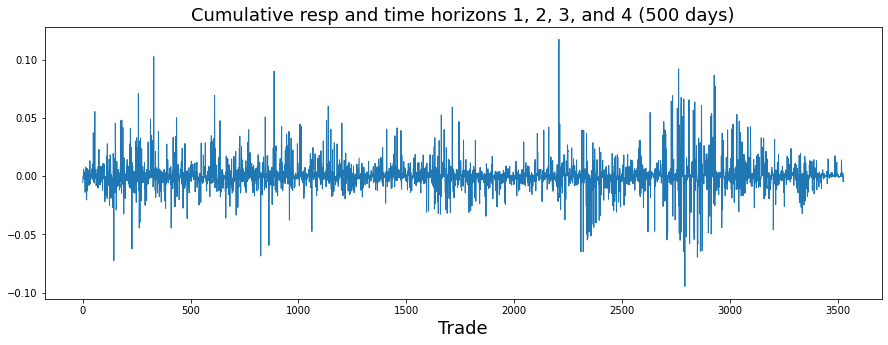

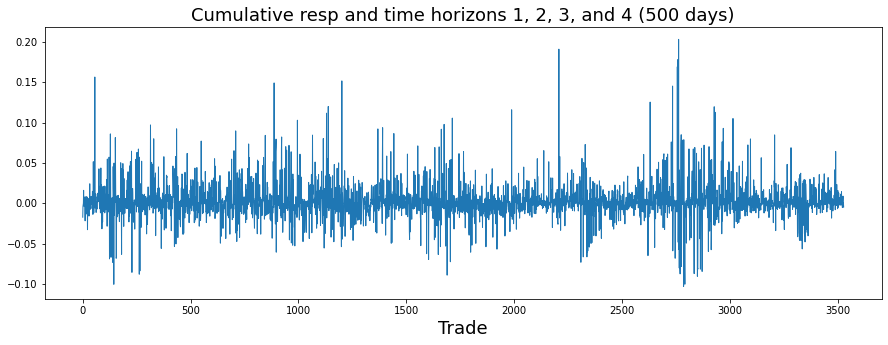

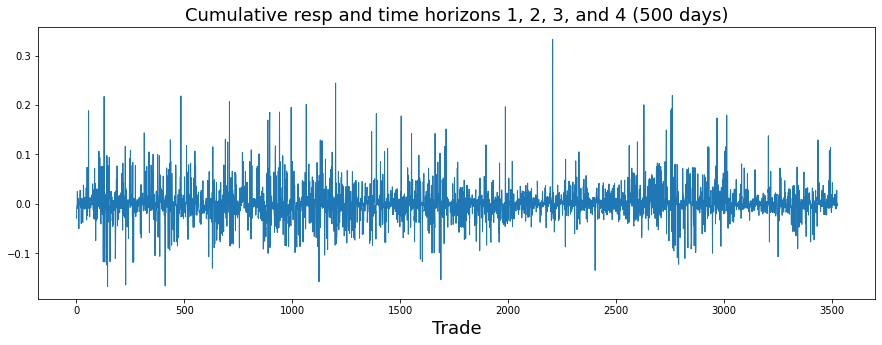

In [178]:
balance= pd.Series(train['resp'])[:3528]
resp_1= pd.Series(train['resp_1'])[:3528]
resp_2= pd.Series(train['resp_2'])[:3528]
resp_3= pd.Series(train['resp_3'])[:3528]
resp_4= pd.Series(train['resp_4'])[:3528]
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp (500 days)", fontsize=18)
balance.plot(lw=1)
plt.show()
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
resp_1.plot(lw=1)
plt.show()
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
resp_2.plot(lw=1)
plt.show()
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
resp_3.plot(lw=1)
plt.show()
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
resp_4.plot(lw=1)
plt.show()
del resp_1
del resp_2
del resp_3
del resp_4
gc.collect();